<a href="https://colab.research.google.com/github/Layantt/Data-Science-Project/blob/main/DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, re, pandas as pd
from pathlib import Path
from IPython.display import display
from google.colab import files
OUT = Path("raw_data"); OUT.mkdir(exist_ok=True)


In [3]:
# Required Libraries Installation
import subprocess, sys, os, re
from datetime import datetime

def install_packages():
    packages = ["requests", "beautifulsoup4", "pandas", "lxml", "urllib3", "certifi"]
    for package in packages:
        try:
            __import__(package.replace("beautifulsoup4", "bs4"))
        except ImportError:
            subprocess.run([sys.executable, "-m", "pip", "install", package], check=True)

install_packages()

# Imports
import requests, pandas as pd
import certifi
from bs4 import BeautifulSoup
from google.colab import files
from pathlib import Path
import urllib3

# Disable only the SSL warning if we fall back to verify=False
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Output dir
output_dir = Path("raw_data")
output_dir.mkdir(exist_ok=True)
html_file = output_dir / "pdpl_raw_html.html"
csv_file  = output_dir / "pdpl_articles_enhanced.csv"

url = "https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}

print("Starting enhanced data collection with article status detection...")

def fetch_with_fallback(url, headers, timeout=30):
    """
    1) Try with default CA bundle (secure)
    2) Try with certifi.where() (explicit CA path)
    3) Last resort: verify=False (insecure, but pragmatic for Colab scraping)
    """
    try:
        r = requests.get(url, headers=headers, timeout=timeout)  # default
        r.raise_for_status()
        return r, "secure-default"
    except Exception as e1:
        try:
            r = requests.get(url, headers=headers, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r, "secure-certifi"
        except Exception as e2:
            # Final fallback (NOT for prod; just to proceed in Colab)
            r = requests.get(url, headers=headers, timeout=timeout, verify=False)
            r.raise_for_status()
            return r, "insecure-fallback"

try:
    response, mode = fetch_with_fallback(url, headers)
    print(f"HTTP GET OK via mode: {mode} | status={response.status_code}")

    # Save raw HTML for inspection
    html_file.write_text(response.text, encoding="utf-8")
    print(f"Raw HTML saved: {html_file}")

    soup = BeautifulSoup(response.text, "lxml")

    # Try structured extraction first
    articles_from_html = []
    article_divs = soup.find_all("div", class_="article_item")

    if article_divs:
        print(f"Found {len(article_divs)} article divs in HTML structure")
        for div in article_divs:
            classes = div.get("class", [])
            if "changed-article" in classes:
                article_status = "معدلة"
            elif "no_alternate" in classes:
                article_status = "أصلية"
            else:
                article_status = "غير محدد"

            title_element = div.find("h3")
            article_title = title_element.get_text(strip=True) if title_element else "عنوان غير محدد"

            content_div = div.find("div", class_="HTMLContainer")
            if content_div:
                article_text = content_div.get_text(separator=" ", strip=True)
                modification_text = "لا يوجد نص معدل"

                if article_status == "معدلة":
                    popup_div = div.find("div", class_="article_item_popup")
                    if popup_div:
                        popup_content = popup_div.find("div", class_="HTMLContainer")
                        if popup_content:
                            popup_text = popup_content.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text
                        else:
                            popup_text = popup_div.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text

                if article_text and len(article_text) > 10:
                    articles_from_html.append({
                        "article_title": article_title,
                        "article_text": article_text,
                        "article_status": article_status,
                        "modification_text": modification_text
                    })

    # Fallback to text parsing if needed
    articles_from_text = []
    if not articles_from_html:
        print("No structured HTML found, falling back to text extraction...")
        text = soup.get_text(separator="\n", strip=True)
        lines = text.split("\n")
        current_article, current_content, article_found = None, [], False

        for line in lines:
            line = line.strip()
            if not line:
                continue
            if re.match(r"^المادة\s+", line):
                if current_article and current_content and article_found:
                    article_text = " ".join(current_content).strip()
                    if len(article_text) > 10:
                        article_status = "أصلية"
                        modification_text = "لا يوجد نص معدل"
                        if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                            article_status = "معدلة"
                            patterns = [
                                r'عُدلت هذه المادة.*?"(.*?)"',
                                r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                                r'لتكون بالنص الآتي.*?"(.*?)"'
                            ]
                            for pattern in patterns:
                                m = re.search(pattern, article_text, re.DOTALL)
                                if m:
                                    modification_text = m.group(1).strip()
                                    break
                            if modification_text == "لا يوجد نص معدل":
                                mod_start = article_text.find("عُدلت هذه المادة")
                                if mod_start != -1:
                                    modification_text = article_text[mod_start:mod_start+200] + "..."

                        articles_from_text.append({
                            "article_title": current_article,
                            "article_text": article_text,
                            "article_status": article_status,
                            "modification_text": modification_text
                        })
                current_article, current_content, article_found = line, [], True
            else:
                if current_article and article_found:
                    if len(line) <= 3:
                        continue
                    skip_line = False
                    if (line.startswith("تاريخ") or line.startswith("رقم") or
                        line.startswith("الجريدة الرسمية") or line.startswith("*") or line.startswith("-")):
                        skip_line = True
                    admin_only = ["تعديلات المادة", "مادة معدلة", "مادة ملغية"]
                    line_lower = line.lower()
                    for pat in admin_only:
                        if pat in line_lower and len(line) < 150 and line.count('.') <= 1:
                            skip_line = True
                            break
                    if not skip_line:
                        current_content.append(line)

        if current_article and current_content and article_found:
            article_text = " ".join(current_content).strip()
            if len(article_text) > 10:
                article_status = "أصلية"
                modification_text = "لا يوجد نص معدل"
                if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                    article_status = "معدلة"
                    patterns = [
                        r'عُدلت هذه المادة.*?"(.*?)"',
                        r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                        r'لتكون بالنص الآتي.*?"(.*?)"'
                    ]
                    for pattern in patterns:
                        m = re.search(pattern, article_text, re.DOTALL)
                        if m:
                            modification_text = m.group(1).strip()
                            break
                    if modification_text == "لا يوجد نص معدل":
                        mod_start = article_text.find("عُدلت هذه المادة")
                        if mod_start != -1:
                            modification_text = article_text[mod_start:mod_start+200] + "..."

                articles_from_text.append({
                    "article_title": current_article,
                    "article_text": article_text,
                    "article_status": article_status,
                    "modification_text": modification_text
                })

    # Prefer HTML-based; else text-based; else empty
    articles = articles_from_html if articles_from_html else articles_from_text

    # Build DataFrame (even if empty, but with columns)
    cols = ["article_title", "article_text", "article_status", "modification_text"]
    df = pd.DataFrame(articles, columns=cols)

    # Basic cleaning
    if not df.empty:
        df = df[df["article_text"].astype(str).str.len() > 10]
        df = df.drop_duplicates(subset=["article_title"])
        first_articles = df[df["article_title"].astype(str).str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
        if len(first_articles) > 1:
            print("Detected duplicate first article - fixing...")
            best_first = first_articles.loc[first_articles["article_text"].str.len().idxmax()]
            df = df[~df["article_title"].str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
            df = pd.concat([pd.DataFrame([best_first]), df]).reset_index(drop=True)

    # Always write a CSV so Cell 2 never fails with FileNotFound
    df.to_csv(csv_file, index=False, encoding="utf-8-sig")
    print(f"Successfully extracted {len(df)} articles with status information!")
    print(f"Enhanced data saved to: {csv_file}")

    # Quick stats
    print("CWD:", Path.cwd())
    print("raw_data contents:", [p.name for p in output_dir.iterdir()])

    if not df.empty:
        print("\n Article Status Summary:")
        print("-" * 40)
        for status, count in df['article_status'].value_counts().items():
            print(f"• {status}: {count} مادة")

except Exception as e:
    # As a last resort, create an empty CSV with columns so Cell 2 won't crash
    print(f" Error in data collection: {e}")
    if not csv_file.exists():
        pd.DataFrame(columns=["article_title", "article_text", "article_status", "modification_text"]).to_csv(csv_file, index=False, encoding="utf-8-sig")
        print("Created empty CSV due to error, to keep the pipeline alive.")

print("\n Files saved in directory:", output_dir)
print(" Enhanced data collection completed (with fallbacks).")
try:
    files.download(str(html_file))
    files.download(str(csv_file))
except:
    print(" Files ready for download in the output directory")


Starting enhanced data collection with article status detection...
HTTP GET OK via mode: insecure-fallback | status=200
Raw HTML saved: raw_data/pdpl_raw_html.html
Found 43 article divs in HTML structure
Successfully extracted 43 articles with status information!
Enhanced data saved to: raw_data/pdpl_articles_enhanced.csv
CWD: /content
raw_data contents: ['pdpl_articles_enhanced.csv', 'pdpl_raw_html.html']

 Article Status Summary:
----------------------------------------
• معدلة: 24 مادة
• أصلية: 19 مادة

 Files saved in directory: raw_data
 Enhanced data collection completed (with fallbacks).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# secondary data

In [4]:
SOURCES = [
    "https://www.dlapiper.com/en/insights/publications/2024/02/saudi-arabias-new-personal-data-protection-law-in-force",
    "https://www.mdpi.com/2075-471X/14/4/47"
]

def build_secondary():
    data = [
        ["id","question","answer"],

        [1, "ما الهدف من تشريعات حماية البيانات؟",
         "حماية خصوصية الأفراد مع السماح للجهات باستخدام البيانات عند الحاجة وبشكل قانوني ومتناسب"],

        [2, "لماذا تسعى الدول لمواءمة أنظمة حماية البيانات مع المعايير العالمية؟",
         "لدعم الثقة العابرة للحدود واتباع الممارسات الدولية وضمان شفافية القطاعات مثل التأمين"],

        [3, "ما التحدي الذي تُحدثه التقنيات الرقمية في حماية البيانات؟",
         "إمكانية جمع وتخزين ومشاركة البيانات على نطاق واسع مما يزيد مخاطر إساءة الاستخدام"],

        [4, "ما المبدأ المستخدم لموازنة خصوصية الأفراد واحتياجات الجهات؟",
         "اختبار الضرورة والتناسب الذي يقيم مدى الحاجة الفعلية للمعالجة وملاءمتها للخصوصية"],

        [5, "لماذا تعد الشفافية أساسية في قطاع التأمين؟",
         "لأن القطاع يعتمد على البيانات الشخصية والحساسة، والشفافية تعزز ثقة المتعاملين"],

        [6, "ما سبب تعقيد مسألة الموافقة في التأمين الإلزامي؟",
         "لأن الفرد مضطر لتقديم بياناته للحصول على خدمة إلزامية، ما يجعل الموافقة غير اختيارية تمامًا"],

        [7, "لماذا تحصل البيانات الحساسة على مستوى حماية أعلى؟",
         "لأن إساءة استخدامها قد تؤثر بشدة على سلامة الفرد وكرامته وفرصه"],

        [8, " متى دخل نظام حماية البيانات الشخصية حيز التنفيذ في السعودية؟(PDPL) ",
         "دخل النظام حيز التنفيذ في 14 سبتمبر 2023 مع فترة تكيّف مدتها 12 شهرًا"],

        [9, "هل يتطلب نظام إجراء تقييم مخاطر لنقل البيانات؟PDPL ",
         "نعم، يجب على المتحكمين إجراء تقييم لمخاطر النقل خصوصًا عند نقل بيانات حساسة أو نقلها بشكل مستمر"],

        [10, " ؟ PDPL ما الأسس النظامية لمعالجة البيانات بموجب ",
         "منها مبدأ المصلحة المشروعة، لكنه لا ينطبق على معالجة البيانات الحساسة"],

        [11, " ؟PDPL هل يجب على الجهات التسجيل لدى جهة سعودية بموجب نظام ",
         "قد يُطلب من الجهات التسجيل لدى الهيئة السعودية للبيانات والذكاء الاصطناعي (سدايا)، مع صدور قواعد لاحقة تحدد الفئات الملزمة"],

        [12, "متى يجب إخطار صاحب البيانات عند حدوث تسريب؟",
         "يجب إخطار صاحب البيانات “دون تأخير غير مبرر” بحسب تفاصيل التسريب"],

        [13, "ما عقوبة الإفشاء المتعمد أو النشر الضار للبيانات الحساسة؟",
         "سنتان كحد أقصى للسجن أو غرامة تصل إلى 3 ملايين ريال سعودي"],

        [14, " ؟PDPL ما الحد الأقصى للغرامة الإدارية بموجب نظام ",
         "غرامة تصل إلى 5 ملايين ريال سعودي للانتهاكات غير الجنائية، وقد تتضاعف هذه الغرامات في حال تكرار المخالفة"],

        [15, "ما المخاطر الناتجة عن الاختيار العكسي في التأمين؟",
         "يمكن أن يؤدي إلى عدم التوازن حيث يمتلك طرف معرفة أكثر من الآخر، ما يخلق مزايا تفاوضية أو تسعيرية غير عادلة"],

        [16, "لماذا تعتبر البيانات الجينية من أصعب الفئات تنظيمًا؟",
         "لأنها تكشف معلومات شخصية وعائلية عميقة، يمكن أن تتنبأ بالنتائج الصحية المستقبلية، وتثير صدامات بين الخصوصية الفردية وأهداف الصحة العامة أو البحث"],

        [17, "لماذا يصعب تقييم النجاح طويل الأمد للقوانين الجديدة لحماية البيانات؟",
         "لأن التقييم الفعّال يتطلب سنوات من بيانات التطبيق مثل حالات التسريب والعقوبات وأنماط الامتثال الفعلية"]
    ]

    header, rows = data[0], data[1:]

    def clean(x):
        x = str(x).strip()
        x = re.sub(r"[^\w\s\u0600-\u06FF\-\–\—.,;؟?!%()«»]+", "", x)
        return re.sub(r"\s+", " ", x)

    cleaned = [[clean(v) for v in r] for r in rows]

    df_secondary = pd.DataFrame(cleaned, columns=header)

    path = OUT / "pdpl_secondary_nonofficial.csv"
    df_secondary.to_csv(path, index=False, encoding="utf-8-sig")

    display(df_secondary)
    files.download(str(path))

    print("saved ", path)
    return df_secondary


df_secondary = build_secondary()




,id,question,answer
0,1,ما الهدف من تشريعات حماية البيانات؟,حماية خصوصية الأفراد مع السماح للجهات باستخدام...
1,2,لماذا تسعى الدول لمواءمة أنظمة حماية البيانات ...,لدعم الثقة العابرة للحدود واتباع الممارسات الد...
2,3,ما التحدي الذي تُحدثه التقنيات الرقمية في حماي...,إمكانية جمع وتخزين ومشاركة البيانات على نطاق و...
3,4,ما المبدأ المستخدم لموازنة خصوصية الأفراد واحت...,اختبار الضرورة والتناسب الذي يقيم مدى الحاجة ا...
4,5,لماذا تعد الشفافية أساسية في قطاع التأمين؟,لأن القطاع يعتمد على البيانات الشخصية والحساسة...
5,6,ما سبب تعقيد مسألة الموافقة في التأمين الإلزامي؟,لأن الفرد مضطر لتقديم بياناته للحصول على خدمة ...
6,7,لماذا تحصل البيانات الحساسة على مستوى حماية أعلى؟,لأن إساءة استخدامها قد تؤثر بشدة على سلامة الف...
7,8,متى دخل نظام حماية البيانات الشخصية حيز التنفي...,دخل النظام حيز التنفيذ في 14 سبتمبر 2023 مع فت...
8,9,هل يتطلب نظام إجراء تقييم مخاطر لنقل البيانات؟...,نعم، يجب على المتحكمين إجراء تقييم لمخاطر النق...
9,10,؟ PDPL ما الأسس النظامية لمعالجة البيانات بموجب,منها مبدأ المصلحة المشروعة، لكنه لا ينطبق على ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saved  raw_data/pdpl_secondary_nonofficial.csv


# Data Processing and Cleaning

In [5]:
from pathlib import Path
import pandas as pd

base = Path("raw_data")
print("CWD:", Path.cwd())
print("raw_data contents:", [p.name for p in base.glob("*")])

target = base / "pdpl_articles_enhanced.csv"
if not target.exists():
    raise FileNotFoundError("CSV not found. Re-run Cell 1 successfully first.")

# ترميز utf-8-sig
df = pd.read_csv(target, encoding="utf-8-sig")
print("Loaded file:", target)
print("Initial shape:", df.shape)
df.info()

# checking out
display(df.head(2))


CWD: /content
raw_data contents: ['pdpl_articles_enhanced.csv', 'pdpl_secondary_nonofficial.csv', 'pdpl_raw_html.html']
Loaded file: raw_data/pdpl_articles_enhanced.csv
Initial shape: (43, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
dtypes: object(4)
memory usage: 1.5+ KB


,article_title,article_text,article_status,modification_text
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,معدلة,- صدر المرسوم الملكي رقم (م/148) وتاريخ 1444/9...
1,المادة الثانية,يُطبق النظام على أي عملية مُعالجة لبيانات شخصي...,أصلية,لا يوجد نص معدل


In [6]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated(subset=["article_title"]).sum()
print(f"\nDuplicate articles found: {duplicates}")

# Display sample
df.head()



Missing values per column:
article_title        0
article_text         0
article_status       0
modification_text    0
dtype: int64

Duplicate articles found: 0


,article_title,article_text,article_status,modification_text
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,معدلة,- صدر المرسوم الملكي رقم (م/148) وتاريخ 1444/9...
1,المادة الثانية,يُطبق النظام على أي عملية مُعالجة لبيانات شخصي...,أصلية,لا يوجد نص معدل
2,المادة الثالثة,لا تخل الأحكام والإجراءات المنصوص عليها في الن...,أصلية,لا يوجد نص معدل
3,المادة الرابعة,يكون لصاحب البيانات الشخصية -وفقاً للأحكام الو...,معدلة,- عُدلت هذه المادة وذلك بموجب المرسوم الملكي ر...
4,المادة الخامسة,فيما عدا الأحوال المنصوص عليها في النظام، لا ت...,معدلة,"- إحلال كلمة ""صريحة"" محل كلمة ""كتابية"" الواردة..."


In [7]:
import re

def clean_text(text):
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove non-Arabic or special symbols if any
    text = re.sub(r'[^\u0600-\u06FF\s.,؛:،]', '', text)
    return text.strip()

# Apply cleaning
df["article_text"] = df["article_text"].apply(clean_text)
df["modification_text"] = df["modification_text"].apply(clean_text)


In [8]:
# Normalize status column to ensure consistency
df["article_status"] = df["article_status"].replace({
    "معدلة": "Modified",
    "أصلية": "Original",
    "غير محدد": "Unknown"
})


In [9]:
# Save the cleaned and processed dataset
cleaned_file = "raw_data/pdpl_cleaned.csv"
df.to_csv(cleaned_file, index=False, encoding="utf-8-sig")

print(f" Cleaned dataset saved to: {cleaned_file}")


 Cleaned dataset saved to: raw_data/pdpl_cleaned.csv


In [10]:
#Download
from google.colab import files
files.download("raw_data/pdpl_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploratory Data Analysis (EDA):
## for both primary and secondary

#### in this section we'll show:

1. Statistical Patterns
2. Visualizations
3. Text Correlations
4. Metadata Review
5. Bias Awareness


## **EDA for primary data:**

 ## 1. Statistical Summaries (Uncover patterns, trends, and anomalies):

In [11]:
import re

def tokenize_ar(text):
    return re.findall(r"[\u0600-\u06FF]+", str(text))


Cloning into 'Data-Science-Project'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 136 (delta 44), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (136/136), 546.00 KiB | 4.92 MiB/s, done.
Resolving deltas: 100% (44/44), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 10.2 MB/s eta 0:00:00
Loaded 799 Arabic stopwords.
Current matplotlib font family: ['Amiri']


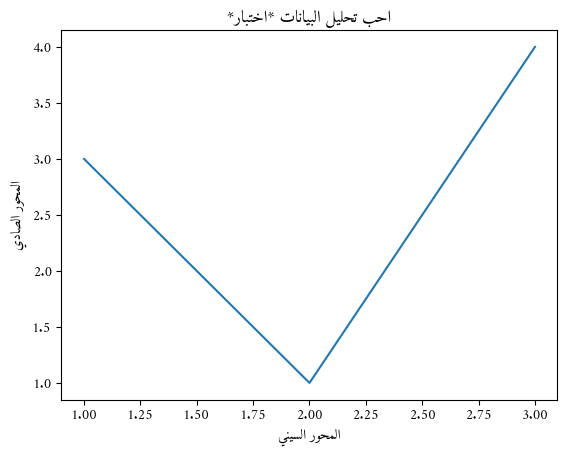

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
dtypes: object(4)
memory usage: 1.5+ KB


,article_title,article_text,article_status,modification_text
count,43,43,43,43
unique,43,43,2,25
top,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارا...,Modified,لا يوجد نص معدل
freq,1,1,24,19


In [12]:
df = pd.read_csv('raw_data/pdpl_cleaned.csv')
# exploring the table
# 1) Clone the repo (will create a folder: Data-Science-Project)
# i chose this method so that my team don't have to upload each file in their devices
# Colab is smart enough to clone it from the reposetary

!git clone https://github.com/Layantt/Data-Science-Project.git

# 2) Install libs for proper Arabic rendering (optional but useful)
!pip install arabic-reshaper python-bidi -q

# 3) Imports

import matplotlib.pyplot  as plt
from matplotlib import font_manager, rcParams
import arabic_reshaper
from bidi.algorithm import get_display

# 4) Paths inside the cloned repo
STOPWORDS_PATH = "Data-Science-Project/data/arabic_stopwords.txt"
FONT_PATH      = "Data-Science-Project/fonts/Amiri-Regular.ttf"

# 5) Load Arabic stopwords from file
with open(STOPWORDS_PATH, encoding="utf-8") as f:
    AR_STOP = {w.strip() for w in f if w.strip()}

print(f"Loaded {len(AR_STOP)} Arabic stopwords.")

font_manager.fontManager.addfont(FONT_PATH)
rcParams['font.family'] = 'Amiri'

print("Current matplotlib font family:", rcParams['font.family'])

title = "احب تحليل البيانات *اختبار*"
reshaped = arabic_reshaper.reshape(title)
bidi_title = get_display(reshaped)

plt.figure()
plt.plot([1, 2, 3], [3, 1, 4])
plt.title(bidi_title)
plt.xlabel(get_display(arabic_reshaper.reshape("المحور السيني")))
plt.ylabel(get_display(arabic_reshaper.reshape("المحور الصادي")))
plt.show()


df.info()
print('========================================================')
df.describe()

In [13]:
df = pd.read_csv('raw_data/pdpl_cleaned.csv')

# create a version of the text without stopwords
df["article_no_stop"] = df["article_text"].apply(
    lambda t: " ".join([w for w in tokenize_ar(t) if w not in AR_STOP])
)



df.to_csv("raw_data/pdpl_no_stop.csv", index=False, encoding="utf-8-sig")
print("Saved cleaned file to raw_data/pdpl_no_stop.csv")
df.info()



Saved cleaned file to raw_data/pdpl_no_stop.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   article_title      43 non-null     object
 1   article_text       43 non-null     object
 2   article_status     43 non-null     object
 3   modification_text  43 non-null     object
 4   article_no_stop    43 non-null     object
dtypes: object(5)
memory usage: 1.8+ KB


In [14]:
from google.colab import files
files.download("raw_data/pdpl_no_stop.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# I WILL CONTINUEU THE EDA, I STOPPED HERE ---> **RAWAN**

In [15]:
# calculating the texts length *without the stop words now


df['text_length'] = df['article_no_stop'].str.len()
print(df['article_no_stop'])
print('========================================================')
print(df['article_no_stop'].describe())

0     لغرض تطبيق النظام، يُقصد بالألفاظ والعبارات ال...
1     يُطبق النظام عملية مُعالجة لبيانات شخصية تتعلق...
2     تخل الأحكام والإجراءات المنصوص النظام بأي حكم ...
3     لصاحب البيانات الشخصية وفقاً للأحكام الواردة ا...
4     فيما الأحوال المنصوص النظام، تجوز معالجة البيا...
5     تخضع معالجة البيانات الشخصية للموافقة المشار إ...
6     يجوز الموافقة المشار إليها الفقرة المادة الخام...
7     مراعاة ينص النظام واللوائح شأن الإفصاح البيانا...
8     يجوز لجهة التحكم تحديد مدد لممارسة حق الوصول ا...
9     يجوز لجهة التحكم جمع البيانات الشخصية إلاَّ صا...
10    يجب الغرض جمع البيانات الشخصية علاقة مُباشرة ب...
11    جهة التحكم تعتمد سياسة لخصوصية البيانات الشخصي...
12    جهة التحكم، حالة جمع البيانات الشخصية صاحبها م...
13    يجوز لجهة التحكم تعالج البيانات الشخصية اتخاذ ...
14    يجوز لجهة التحكم الإفصاح البيانات الشخصية إلاّ...
15    جهة التحكم ألاّ تفصح البيانات الشخصية الأحوال ...
16    جرى تصحيح خطأ إكمال نقص إجراء تحديث البيانات ا...
17    جهة التحكم إتلاف البيانات الشخصية فور انته

In [16]:
# calculate how many words in the article text column
# article_no_stop for "article_text"

df['word_count'] = df['article_no_stop'].apply(lambda x: len(x.split()))
print(df['word_count'].describe())

count     43.000000
mean      64.953488
std       57.035475
min        8.000000
25%       25.000000
50%       60.000000
75%       81.500000
max      362.000000
Name: word_count, dtype: float64


In [17]:
# show the outliers *this is the main goal now

threshold_high = df['word_count'].quantile(0.95)
threshold_low = df['word_count'].quantile(0.05)

df_outliers = df[(df['word_count'] < threshold_low) | (df['word_count'] > threshold_high)]

# print(df_outliers) {too messy}

# to make output more clear
df_outliers.style.set_caption("Outliers in word count")


,article_title,article_text,article_status,modification_text,article_no_stop,text_length,word_count
0,المادة الأولى,لغرض تطبيق هذا النظام، يُقصد بالألفاظ والعبارات الآتية أينما وردت في هذا النظام المعاني المبينة أمام كل منها، ما لم يقتضِ السياق غير ذلك: النظام: نظام حماية البيانات الشخصية. اللوائح: اللوائح التنفيذية للنظام. الجهة المختصة: الجهة التي يصدر بتحديدها قرار من مجلس الوزراء. البيانات الشخصية: كل بيان مهما كان مصدره أو شكله من شأنه أن يؤدي إلى معرفة الفرد على وجه التحديد، أو يجعل التعرف عليه ممكنًا بصفة مباشرة أو غير مباشرة، ومن ذلك: الاسم، ورقم الهوية الشخصية، والعناوين، وأرقام التواصل، وأرقام الرُّخص والسجلات والممتلكات الشخصية، وأرقام الحسابات البنكية والبطاقات الائتمانية، وصور الفرد الثابتة أو المتحركة، وغير ذلك من البيانات ذات الطابع الشخصي. المُعالجة: أي عملية تُجرى على البيانات الشخصية بأي وسيلة كانت يدوية أو آلية، ومن ذلك: عمليات الجمع، والتسجيل، والحفظ، والفهرسة، والترتيب، والتنسيق، والتخزين، والتعديل، والتحديث، والدمج، والاسترجاع، والاستعمال، والإفصاح، والنقل، والنشر، والمشاركة في البيانات أو الربط البيني، والحجب، والمسح، والإتلاف. الجمع: حصول جهة التحكم على البيانات الشخصية وفقاً لأحكام النظام، سواء من صاحبها مُباشرةً أو ممن يُمثله أو ممن له الولاية الشرعية عليه أو من طرف آخر. الإتلاف: كل عمل يؤدي إلى إزالة البيانات الشخصية ويجعل من المتعذر الاطلاع عليها أو استعادتها مرة أخرى. الإفصاح: تمكين أي شخص عدا جهة التحكم من الحصول على البيانات الشخصية أو استعمالها أو الاطلاع عليها بأي وسيلة ولأي غرض. النقل: نقل البيانات الشخصية من مكان إلى آخر لمعالجتها. النشر: بث أي من البيانـات الشخصية عبـر وسيلـة نشـر مقـروءة أو مسموعـة أو مرئية، أو إتاحتها. البيانات الحساسة: كل بيان شخصي يتضمن الإشارة إلى أصل الفرد العرقي أو أصله القبلي، أو معتقده الديني أو الفكري أو السياسي، أو يدل على عضويته في جمعيات أو مؤسسات أهلية. وكذلك البيانات الجنائية والأمنية، أو بيانات السمات الحيوية التي تحدد الهوية، أو البيانات الوراثية، أو البيانات الائتمانية، أو البيانات الصحية، وبيانات تحديد الموقع، والبيانات التي تدل على أن الفرد مجهول الأبوين أو أحدهما. البيانات الوراثية: كل بيان شخصي يتعلق بالخصائص الوراثية أو المكتسبة لشخص طبيعي، يحدد بشكل فريد السمات الفيسيولوجية أو الصحية لذلك الشخص، ويستخلص من تحليل عينة بيولوجية للشخص كتحليل الأحماض النووية أو تحليل أي عينة أخرى تؤدي إلى استخلاص بيانات وراثية. البيانات الصحية: كل بيان شخصي يتعلق بحالة الفرد الصحية، سواء الجسدية أو العقلية أو النفسية أو المتعلقة بالخدمات الصحية الخاصة به. الخدمات الصحية: الخدمات المتعلقة بصحة الفرد، ومن ذلك الخدمات الوقائية والعلاجية والتأهيلية والتنويم وتوفير الدواء. البيانات الائتمانية: كل بيان شخصي يتعلق بطلب الفرد الحصول على تمويل، أو حصوله عليه، سواء لغرض شخصي أو عائلي، من جهة تُمارس التمويل، بما في ذلك أي بيان يتعلق بقدرته على الحصول على ائتمان أو بقدرته على الوفاء به أو بتاريخه الائتماني. صاحب البيانات الشخصية: الفرد الذي تتعلق به البيانات الشخصية أو من يمثله أو من له الولاية الشرعية عليه. الجهة العامة: أي وزارة أو مصلحة أو مؤسسة عامة أو هيئة عامة، أو أي جهة عامة مستقلة في المملكة، أو أي من الجهات التابعة لها. جهة التحكم: أي جهة عامة، وأي شخصية ذات صفة طبيعية أو اعتبارية خاصة؛ تحدد الغرض من معالجة البيانات الشخصية وكيفية ذلك؛ سواء أباشرت معالجة البيانات بوساطتها أم بوساطة جهة المعالجة. جهة المعالجة: أي جهة عامة، وأي شخصية ذات صفة طبيعية أو اعتبارية خاصة؛ تعالج البيانات الشخصية لمصلحة جهة التحكم ونيابةً عنها.,Modified,صدر المرسوم الملكي رقم م وتاريخ هـ، وذلك بتعديل التعريفات الآتية: الإتلاف ، الإفصاح ، البيانات الحساسة ، صاحب البيانات الشخصية وتكون على النحو الآتي: الإتلاف: أي إجراء يتم على البيانات الشخصية ويجعل من المتعذر الاطلاع عليها أو استعادتها مرة أخرى أو معرفة صاحبها على وجه التحديد . الإفصاح: تمكين أي شخص عدا جهة التحكم أو جهة المعالجة بحسب الأحوال من الحصول على البيانات الشخصية أو استعمالها أو الاطلاع عليها بأي وسيلة ولأي غرض . البيانات الحساسة: كل بيان شخصي يتعلق بأصل الفرد العرقي أو أصله الإثني، أو معتقده الديني أو الفكري أو السياسي. وكذلك البيانات الأمنية والجنائية، أو بيانات السمات الحيوية التي تحدد الهوية، أو البيانات الوراثية، أو البيانات الصحية، والبيانات التي تدل على أن الفرد مجهول الأبوين أو أحدهما . صاحب البيانات الشخصية: الفرد الذي تتعلق به البي

## 2. Visualization:

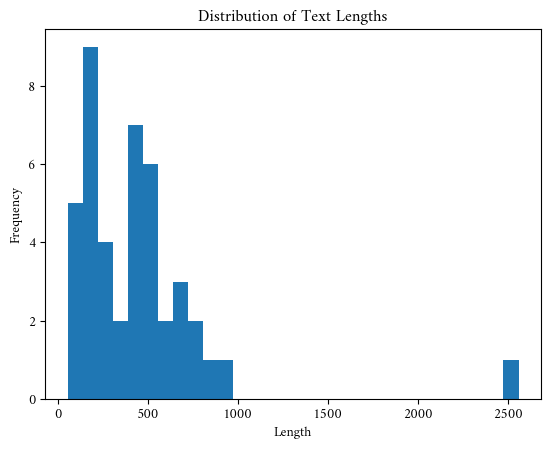

In [18]:
# Histogram for texts length
import matplotlib.pyplot as plt


plt.hist(df['text_length'], bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

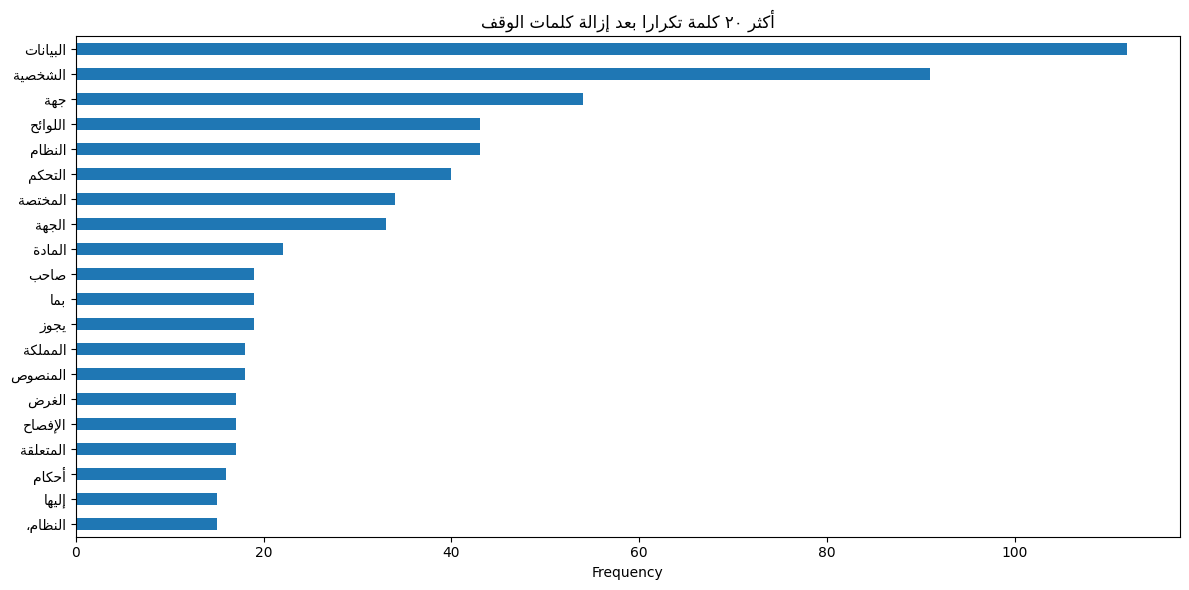

In [28]:
# # Bar Plot for most repetitive words:

import re
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt

# 1) build the big text
text = " ".join(df['article_no_stop'].astype(str))

# 2) better tokenization for Arabic (avoid \w+)
tokens = re.findall(r"[\u0600-\u06FF]+", text)

# 3) top 20 frequencies
word_freq = pd.Series(tokens).value_counts().head(20)

# 4) reshape Arabic labels for plotting
labels = [
    get_display(arabic_reshaper.reshape(str(w)))
    for w in word_freq.sort_values().index
]

plt.figure(figsize=(12,6))
word_freq.sort_values().plot(kind='barh')  # خليه بدون title بالعربي الآن
plt.title(get_display(arabic_reshaper.reshape("أكثر ٢٠ كلمة تكرارًا بعد إزالة كلمات الوقف")))
plt.xlabel('Frequency')

# 5) override y-ticks with reshaped Arabic labels
plt.yticks(range(len(labels)), labels)

plt.tight_layout()
plt.show()


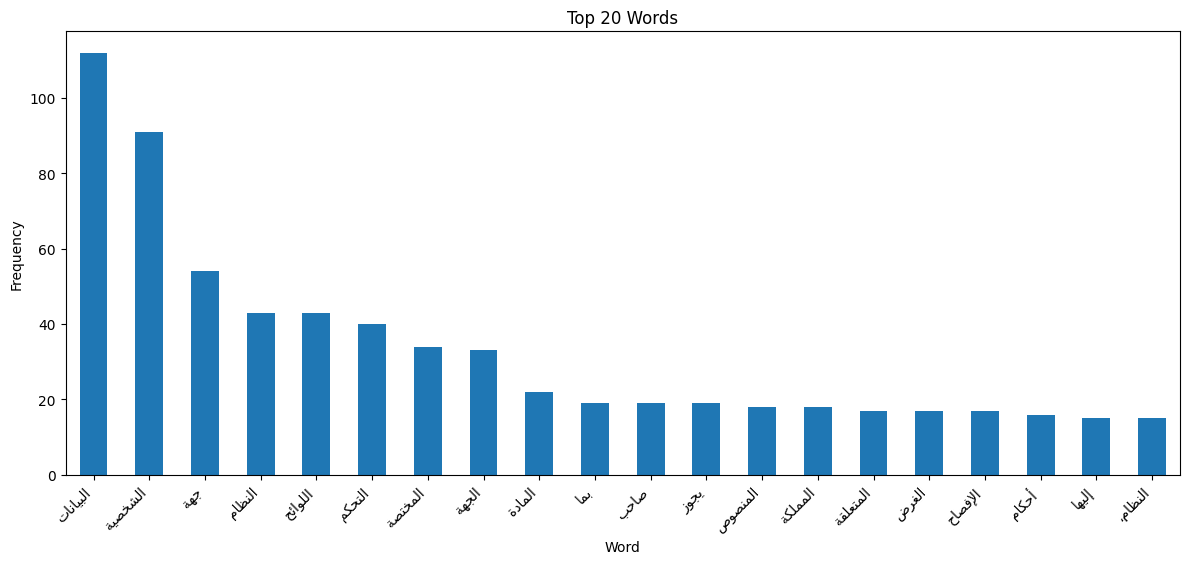

In [30]:
# most repetitive words
# using pandas

from collections import Counter
import pandas as pd, matplotlib.pyplot as plt
import re, arabic_reshaper
from bidi.algorithm import get_display

# TAKING THE COLUMN 'article_no_stop' TO COUNT ITS TOKENS
text_col = 'article_no_stop' if 'article_no_stop' in df.columns else 'answer'

# بدل split العادي، نستخدم regex ياخذ فقط كلمات عربية متصلة (أفضل للعربي)
text = ' '.join(df[text_col].astype(str))
tokens = re.findall(r"[\u0600-\u06FF]+", text)         #CALCULATING TOKENS

# I NNED TO FILTER TOKENS AND TAKE THOSE WITH > 2 LETTERS
tokens = [w for w in tokens if len(w) > 2]

freq = pd.Series(Counter(tokens)).sort_values(ascending=False).head(20)

#  بعيد تشكيل الكلمات العربية عشان تنعرض صح على محور x
labels = [
    get_display(arabic_reshaper.reshape(str(w)))
    for w in freq.index
]

ax = freq.plot(kind='bar', figsize=(12,6))
plt.title(get_display(arabic_reshaper.reshape('Top 20 Words')))
plt.xlabel(get_display(arabic_reshaper.reshape('Word')))
plt.ylabel('Frequency')
plt.tight_layout()

# بركب الـ labels المعاد تشكيلها بدل الأصلية
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.show()


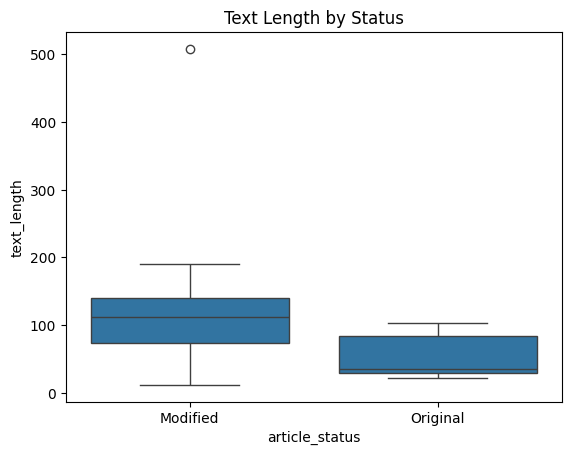

In [31]:
# Boxplot لطول النصوص حسب حالة المادة
import seaborn as sns

df['article_no_stop'] = df['article_no_stop'].apply(lambda x: len(str(x).split())) # add the column text len

sns.boxplot(x='article_status', y='text_length', data=df)
plt.title('Text Length by Status')
plt.show()

## 3. Correlation / Relationships analysis

In [34]:
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

# نتأكد أن الأعمدة المطلوبة موجودة
assert {'article_no_stop','article_status'}.issubset(df.columns), "Expected columns missing."
df = df.copy()

# Tokenizer
def tokenize_ar(text):
    return re.findall(r"\w+", str(text), flags=re.UNICODE)

# Length / word count بناءً على النص بعد إزالة كلمات الوقف
if 'text_length' not in df.columns:
    df['text_length'] = df['article_no_stop'].apply(lambda x: len(str(x)))
if 'word_count' not in df.columns:
    df['word_count'] = df['article_no_stop'].apply(lambda x: len(tokenize_ar(x)))

print("=== Length / Count by Status ===")
display(
    df.groupby('article_status')[['word_count','text_length']]
      .agg(['mean','median','min','max','std'])
      .round(2)
)

# Top words per status (على article_no_stop مباشرة)
print("\n=== Top Words per Status (stopwords removed already) ===")
for status in df['article_status'].unique():
    subset = df[df['article_status'] == status]
    toks = []
    for t in subset['article_no_stop']:
        toks.extend(tokenize_ar(t))
    toks = [w for w in toks if len(w) > 1]
    top = Counter(toks).most_common(15)
    top_df = pd.DataFrame(top, columns=['word','count'])
    print(f"\n[Status = {status}]")
    display(top_df)

# TF-IDF:
print("\n=== TF-IDF Distinctive Terms per Status ===")
vectorizer = TfidfVectorizer(
    max_features=2000,
    analyzer='word',
    token_pattern=r'\w+',
    lowercase=False
)

# 👇 هنا التحويل لنص عشان نتفادى TypeError
docs = df['article_no_stop'].fillna("").astype(str)
X = vectorizer.fit_transform(docs)
vocab = np.array(vectorizer.get_feature_names_out())

mask_mod = (df['article_status'] == 'Modified').to_numpy()
mask_org = (df['article_status'] == 'Original').to_numpy()
idx_mod = np.where(mask_mod)[0]
idx_org = np.where(mask_org)[0]

if idx_mod.size > 0:
    mean_mod = np.asarray(X[idx_mod].mean(axis=0)).ravel()
else:
    mean_mod = np.zeros(X.shape[1])

if idx_org.size > 0:
    mean_org = np.asarray(X[idx_org].mean(axis=0)).ravel()
else:
    mean_org = np.zeros(X.shape[1])

def top_terms(mean_vec, k=15):
    idx = mean_vec.argsort()[::-1][:k]
    return pd.DataFrame({'term': vocab[idx], 'score': mean_vec[idx]})

print("\nTop TF-IDF terms (Modified):")
display(top_terms(mean_mod, 15))

print("\nTop TF-IDF terms (Original):")
display(top_terms(mean_org, 15))

diff = mean_mod - mean_org
print("\nMost distinctive FOR Modified (score = mean_mod - mean_org):")
idx_mod_rel = diff.argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_mod_rel], 'score': diff[idx_mod_rel]}))

print("\nMost distinctive FOR Original (score = mean_org - mean_mod):")
idx_org_rel = (-diff).argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_org_rel], 'score': (-diff)[idx_org_rel]}))

# Co-occurrence
print("\n=== Co-occurrence (Top word pairs across articles) ===")
pair_counts = defaultdict(int)
for text in df['article_no_stop']:
    toks = [t for t in tokenize_ar(text) if len(t) > 1]
    if toks:
        # reduce noise
        local_freq = Counter(toks).most_common(50)
        keep = sorted({w for w, _ in local_freq})
        for a, b in combinations(keep, 2):
            pair_counts[(a, b)] += 1

top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:15]
pairs_df = pd.DataFrame(
    [(a, b, c) for (a, b), c in top_pairs],
    columns=['word_a','word_b','co_docs']
)
display(pairs_df)

print("\nCorrelation-style analysis complete.")


=== Length / Count by Status ===


word_count                        text_length                  \
                     mean median min  max    std        mean median min  max   
article_status                                                                 
Modified            86.96   80.5   8  362  66.74      123.46  112.0  12  508   
Original            37.16   26.0  15   73  20.92       50.89   35.0  22  103   

                       
                  std  
article_status         
Modified        94.08  
Original        28.92


=== Top Words per Status (stopwords removed already) ===

[Status = Modified]


,word,count
0,51,2
1,96,2
2,362,1
3,111,1
4,44,1
5,64,1
6,69,1
7,131,1
8,81,1
9,39,1



[Status = Original]


,word,count
0,22,2
1,21,2
2,62,1
3,20,1
4,43,1
5,18,1
6,24,1
7,60,1
8,71,1
9,59,1



=== TF-IDF Distinctive Terms per Status ===

Top TF-IDF terms (Modified):


,term,score
0,96,0.083333
1,51,0.083333
2,84,0.041667
3,93,0.041667
4,82,0.041667
5,81,0.041667
6,8,0.041667
7,80,0.041667
8,64,0.041667
9,69,0.041667



Top TF-IDF terms (Original):


,term,score
0,22,0.105263
1,21,0.105263
2,69,0.052632
3,71,0.052632
4,18,0.052632
5,24,0.052632
6,26,0.052632
7,23,0.052632
8,43,0.052632
9,59,0.052632



Most distinctive FOR Modified (score = mean_mod - mean_org):


,term,score
0,96,0.083333
1,51,0.083333
2,84,0.041667
3,93,0.041667
4,82,0.041667
5,81,0.041667
6,8,0.041667
7,80,0.041667
8,64,0.041667
9,39,0.041667



Most distinctive FOR Original (score = mean_org - mean_mod):


,term,score
0,22,0.105263
1,21,0.105263
2,73,0.052632
3,71,0.052632
4,20,0.052632
5,18,0.052632
6,26,0.052632
7,23,0.052632
8,43,0.052632
9,29,0.052632



=== Co-occurrence (Top word pairs across articles) ===


,word_a,word_b,co_docs



Correlation-style analysis complete.


---

## EDA for secondary data

In this part, we perform Exploratory Data Analysis (EDA) on the **secondary dataset**,  
which contains external Q&A items related to the Saudi Personal Data Protection Law (PDPL).

We will cover:

1. Statistical Patterns  
2. Visualizations  
3. Text Correlations  
4. Metadata Review  
5. Bias Awareness


### 1. Statistical Patterns

In this step, we load the secondary dataset, clean the Arabic text by removing stopwords,  
and compute basic statistics such as text length and word counts for both questions and answers.  
These patterns help us understand how PDPL-related concepts are expressed in external written sources.


In [ ]:
import pandas as pd
import re

# تحميل 
df_sec = pd.read_csv("raw_data/pdpl_secondary_nonofficial.csv", encoding="utf-8-sig")

# لتجزئة الكلمات العربية
def tokenize_ar(text):
    return re.findall(r"[\u0600-\u06FF]+", str(text))

# تحميل كلمات الوقف العربية 
STOPWORDS_PATH = "data/arabic_stopwords.txt"
with open(STOPWORDS_PATH, encoding="utf-8") as f:
    AR_STOP = {w.strip() for w in f if w.strip()}

print("Loaded Arabic stopwords:", len(AR_STOP))

# إنشاء نص من غير كلمات الوقف للسؤال
df_sec["question_no_stop"] = df_sec["question"].apply(
    lambda t: " ".join([w for w in tokenize_ar(t) if w not in AR_STOP])
)

# إنشاء نص من غير كلمات الوقف للإجابة
df_sec["answer_no_stop"] = df_sec["answer"].apply(
    lambda t: " ".join([w for w in tokenize_ar(t) if w not in AR_STOP])
)

# حساب طول النص (عدد الأحرف) للأسئلة والإجابات
df_sec["q_length"] = df_sec["question_no_stop"].str.len()
df_sec["a_length"] = df_sec["answer_no_stop"].str.len()

# حساب عدد الكلمات في الأسئلة والإجابات
df_sec["q_word_count"] = df_sec["question_no_stop"].apply(lambda x: len(x.split()))
df_sec["a_word_count"] = df_sec["answer_no_stop"].apply(lambda x: len(x.split()))

# عرض وصف إحصائي للأطوال وعدد الكلمات
df_sec[["q_length","a_length","q_word_count","a_word_count"]].describe()


### 2. Visualizations

In this step, we visualize the distribution of question and answer lengths,  
and the most frequent words appearing in the secondary dataset.  
These plots give an intuitive understanding of how dense and repetitive the text is.


### 📊 A — Distribution of Question Lengths  
In this step, we visualize the distribution of the textual lengths of the questions in the secondary dataset.  
This plot helps identify whether the questions are short, medium, or long, and whether there are outliers affecting the overall distribution.


In [ ]:
# إعداد الخط العربي 
%pip install arabic-reshaper python-bidi -q

import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import arabic_reshaper
from bidi.algorithm import get_display

# إضافة خط من مجلد المشروع
FONT_PATH = "fonts/Amiri-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams["font.family"] = "Amiri"

# رسم هيستوغرام لطول الأسئلة
plt.figure(figsize=(8,5))
plt.hist(df_sec["q_length"], bins=10)
plt.title(get_display(arabic_reshaper.reshape("توزيع أطوال الأسئلة")))
plt.xlabel(get_display(arabic_reshaper.reshape("الطول")))
plt.ylabel(get_display(arabic_reshaper.reshape("التكرار")))
plt.show()


### 📊 B — Distribution of Answer Lengths  
This histogram visualizes the distribution of answer lengths after cleaning and preprocessing.  
It provides insight into how detailed or concise the answers are, and highlights variations across the dataset.



In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df_sec["a_length"], bins=10)
plt.title(get_display(arabic_reshaper.reshape("توزيع أطوال الإجابات")))
plt.xlabel(get_display(arabic_reshaper.reshape("الطول")))
plt.ylabel(get_display(arabic_reshaper.reshape("التكرار")))
plt.show()


### 📊 C — Top 20 Most Frequent Words (Questions + Answers)  
In this section, we generate a combined word-frequency bar chart for both questions and answers.  
After removing Arabic stopwords, we highlight the 20 most repeated informative words across the secondary dataset.  
This helps reveal the dominant concepts and themes within the collected text.


In [ ]:
from collections import Counter

# دمج نصوص الأسئلة والإجابات بعد إزالة كلمات الوقف
all_text = " ".join(df_sec["question_no_stop"]) + " " + " ".join(df_sec["answer_no_stop"])

# استخراج الكلمات العربية
tokens = re.findall(r"[\u0600-\u06FF]+", all_text)
# فلترة الكلمات القصيرة جداً
tokens = [w for w in tokens if len(w) > 2]

freq = pd.Series(Counter(tokens)).sort_values(ascending=False).head(20)

# إعادة تشكيل النص العربي ليظهر بطريقة صحيحة في الرسم
labels = [get_display(arabic_reshaper.reshape(str(w))) for w in freq.index]

plt.figure(figsize=(12,6))
ax = freq.plot(kind="bar")
ax.set_xticklabels(labels, rotation=45, ha="right")
plt.title(get_display(arabic_reshaper.reshape("أكثر ٢٠ كلمة تكرارًا في البيانات الثانوية")))
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 📊 D — Boxplot Comparison of Question vs. Answer Lengths  
This boxplot provides a side-by-side comparison of the lengths of questions and answers.  
It helps identify differences in text distribution, median length, variability, and potential outliers between the two types of text.


In [ ]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=df_sec[["q_length","a_length"]])
plt.title(get_display(arabic_reshaper.reshape("مقارنة أطوال الأسئلة والإجابات")))
plt.xticks(
    [0,1],
    [
        get_display(arabic_reshaper.reshape("طول السؤال")),
        get_display(arabic_reshaper.reshape("طول الإجابة"))
    ]
)
plt.show()


### 3. Text Correlations

Here we examine simple relationships between questions and answers,  
such as how the length of a question relates to the length of its corresponding answer.  
This gives an indication of how detailed the answers are compared to the questions.


## Correlation & Outliers
We measure Pearson correlation between question and answer lengths, then detect outliers via the IQR rule.


In [27]:
# Pearson correlation
corr = df_sec["q_len"].corr(df_sec["a_len"])
print(f"Pearson correlation (q_len vs a_len): {corr:.3f}")

# IQR outliers
Q1 = df_sec[["q_len","a_len"]].quantile(0.25)
Q3 = df_sec[["q_len","a_len"]].quantile(0.75)
IQR = Q3 - Q1
mask = (df_sec["q_len"] > Q3.q_len + 1.5*IQR.q_len) | (df_sec["a_len"] > Q3.a_len + 1.5*IQR.a_len)
outs = df_sec.loc[mask, ["id","question","answer","q_len","a_len"]]
print(f"\nOutliers count: {len(outs)}")
if len(outs):
    from IPython.display import display
    display(outs.head(5))


Pearson correlation (q_len vs a_len): 0.058

Outliers count: 0


## 4. Metadata Review

 #### The dataset used in this project was collected from the official Saudi Laws Portal managed by the Bureau of Experts at the Council of Ministers, which serves as the authoritative source of Saudi legal texts.

     Source: Saudi Laws Portal (https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1)

- Date Collected: September 2025

- Collection Method: Web scraping using Python libraries (requests, BeautifulSoup) to extract legal articles from the PDPL page. A raw HTML snapshot was stored for reproducibility.

- Language: Arabic

- Number of Records: 43 legal articles (19 original and 24 modified).

- Data Format: CSV (pdpl_articles_enhanced.csv and pdpl_cleaned.csv)

- Descriptive Statistics:

  - Average word count: ~91 words per article (min = 12, max = 508)

  - Average character length: ~544 characters (min = 70, max = 3112)

  - Most frequent words: “البيانات”، “الشخصية”، “جهة”، “التحكم”، “الجهة المختصة”

    *These statistics reveal a high variance in article length and linguistic concentration around specific legal terms, which reflects the formal language and structure of the PDPL. Such characteristics must be considered during analysis to avoid skewed interpretations.*

- Features:

  - article_title: Official title of each article.

  - article_text: Full legal text of each article.

  - article_status: Indicates whether the article is original, modified, or unknown.

  - modification_text: Amendment details if available.

  - category (added manually): Label assigned by the research team to classify articles thematically.

  - text_length: Number of characters in each article text.

  - word_count: Number of words in each article text.

**The secondary data:**

**Dataset description:**  
This secondary dataset consists of a manually curated set of questions and answers (Q&A) about the Personal Data Protection Law (PDPL). It is intended for educational use to support exploratory analysis and downstream experiments.

**Source:**  
Consolidated from non-official educational materials (practice/exam-style Q&A aligned with PDPL concepts). The legal grounding is the official PDPL, but the phrasing of items is not taken verbatim from the Saudi Laws Portal.

**Date collected:**  
October 2025 (update if needed).

**Collection method:**  
Manual curation and light text cleaning using Python (regex + pandas). A CSV export was produced for reproducibility.

**Language & encoding:**  
Arabic (UTF-8 / UTF-8-SIG for CSV).

**Size:**  
30 observations (rows) × 3 features (columns).

**Schema and data types:**  
- `id` (integer): row identifier  
- `question` (string): the PDPL-related question (in Arabic)  
- `answer` (string): a concise Arabic answer consistent with PDPL concepts  

**Derived features (added during EDA):**  
- `q_len` (integer): character length of the question  
- `a_len` (integer): character length of the answer  

**File & format:**  
`raw_data/pdpl_secondary_nonofficial.csv` (CSV, UTF-8-SIG).

**Intended use:**  
Exploratory Data Analysis (EDA) to study distribution of text lengths, compare question vs answer verbosity, inspect outliers, and document potential sources of bias.

**Notes:**  
While items are conceptually aligned with the PDPL, this dataset is not an official transcription; wording reflects educational curation rather than statutory text.

## 5. Bias Analysis


*The Primery dataset consists of 43 legal articles collected from the Saudi Laws Portal, with 24 modified articles and 19 original articles. Although the source is official and reliable, several biases can affect the interpretation of analytical results:*

1. **Source Bias**

All data originates from a single official governmental source, which reflects the formal legal language used by the state. This means it does not represent interpretations from other stakeholders such as legal practitioners, private institutions, or the public.

2. **Linguistic Bias**
The word frequency analysis showed heavy repetition of specific legal terms, such as:

“البيانات” (112 occurrences)

“الشخصية” (82 occurrences)

“جهة” (53 occurrences)

“التحكم” (37 occurrences)

“الجهة المختصة” (31 occurrences)
This repetition may dominate WordClouds and frequency plots, making other contextual words appear less significant — a common limitation in legal corpora.

3. **Distribution Bias**
The word count distribution is uneven:

Mean = 91 words

Min = 12 words (shortest article)

Max = 508 words (longest article)
Some articles are significantly longer than others (e.g., Article 1) and could skew average values or influence models trained on this data if not normalized properly.

4. **Temporal Bias**
The dataset reflects the PDPL as of September 2025. Since the law is subject to amendments, these findings might become outdated with future legal changes. This can affect the long-term validity of any derived insights.

5. **Collection Method Bias**
The dataset was collected via web scraping. Although validated, the extraction process depends on the structure of the web page (DOM). If this structure changes or if some content (e.g., popups) was missed, it could result in incomplete data.

## Bias Analysis — Secondary Data

**Representation bias:**  
Because the Q&A items were manually curated, certain topics (e.g., consent, rights, controller/processor duties) may be over-represented compared to others (e.g., exceptions, international transfers). The set is small (30 items), which further limits coverage.

**Measurement / collection bias:**  
Variation in phrasing style and detail across questions and answers affects measured lengths (`q_len`, `a_len`) and frequency patterns. Selection bias is possible (authors’ preferences, examples seen in courses). Cleaning rules can also influence tokenization and counts.

**Historical / temporal bias:**  
Answers may reflect interpretations at the time of curation and might not capture later amendments or guidance. Without explicit versioning of the law for each Q&A item, temporal drift can occur.

**Source / authority bias:**  
Although conceptually grounded in the official PDPL, the dataset is non-official; it does not incorporate judicial interpretations or regulatory decisions, which can shape real-world application.

**Linguistic / structural bias:**  
Legal Arabic reuses formal terms (e.g., بيانات ، شخصية ، معالجة ، جهة ، متحكم) that dominate frequency analyses and overshadow contextual words.

**Sampling bias:**  
A sample of 30 items is insufficient to generalize patterns across all PDPL topics. The dataset should be treated as illustrative rather than exhaustive.

**Mitigations (recommended):**  
Track PDPL version and date in metadata, expand topic coverage with balanced sampling, document curation criteria, retain original punctuation where informative, and periodically re-validate items against updated legal texts.


# Compare Key Metrics

| Aspect                        | Primary Data (Legal Articles)                | Secondary Data (Q&A Explanations)             |
|-------------------------------|----------------------------------------------|-----------------------------------------------|
| **Type of Content**           | Official legal articles                      | Simplified Q&A explanations                   |
| **Language Style**           | Formal, legal, precise                       | Informal, clear, accessible                   |
| **Purpose**                   | Define and enforce the law                   | Explain and interpret the law                 |
| **Audience**                  | Legal experts and authorities                | General public and learners                   |
| **Format**                    | Long legal paragraphs                        | Short questions and answers                   |
| **Count**                     | 43                                           | 30                                            |
| **Mean**                      | 91.40 words                                  | Q: 34.17 chars — A: 58.80 chars               |
| **Std (Standard Deviation)**  | 80.84                                        | Q: 6.68 — A: 14.66                            |
| **Min**                       | 12                                           | Q: 23 — A: 36                                 |
| **25%**                       | 35.5                                         | Q: 29.25 — A: 50.25                            |
| **50% (Median)**              | 83                                           | Q: 34.0 — A: 57.5                             |
| **75%**                       | 113.5                                        | Q: 39.0 — A: 64.5                             |
| **Max**                       | 508                                          | Q: 46 — A: 99                                 |


 Both datasets are related to the Personal Data Protection Law (PDPL) but serve different purposes
The primary dataset contains the official legal text, while the secondary dataset provides simplified explanations to help the public understand the same concepts.
They complement each other, the primary dataset defines the law, and the secondary one interprets it.

**Summary:**

The primary data presents official and binding legal content, while the secondary data explains it in a simplified way.

There are no contradictions between them — the differences mainly reflect language, purpose, and target audience.

